# Figure 5 - Model validation

Create the figure panels describing the SONIC model validation against the detailed NICE model by comparison of charge density profiles for regular-spiking and low-threshold spiking neurons across the LIFUS parameter space and for various sonophore radii.

### Imports

In [1]:
import os
import logging
import numpy as np
import matplotlib.pyplot as plt
from PySONIC.core import NeuronalBilayerSonophore, PulsedProtocol, AcousticDrive
from PySONIC.postpro import computeSpikingMetrics
from PySONIC.utils import logger, si_format
from PySONIC.neurons import getPointNeuron
from PySONIC.plt import CompTimeSeries, cm2inch
from utils import saveFigsAsPDF, subdirectory, subthr, suprathr

logger.setLevel(logging.INFO)

### Functions

In [2]:
def altLabels(l):
    ''' Add an empty label before each label on an iterable. '''
    return sum([['', x] for x in l], [])

def plotSpikingMetrics(xvar, xlabel, metrics_dict, logscale=False, spikeamp=True, colors=None,
                       fs=8, lw=2, ps=4, figsize=cm2inch(7.25, 5.8), rf=10):
    ''' Plot the evolution of spiking metrics as function of a specific stimulation parameter. '''

    ls = {'full': 'o-', 'sonic': 'o--'}
    cdefault = {'full': 'silver', 'sonic': 'k'}

    # Create figure
    fig, axes = plt.subplots(3, 1, figsize=figsize)
    ibase = 0 if spikeamp else 1
    axes[ibase].set_ylabel('Latency\n (ms)', fontsize=fs, rotation=0, ha='right', va='center')
    axes[ibase + 1].set_ylabel(
        'Firing\n rate (Hz)', fontsize=fs, rotation=0, ha='right', va='center')
    if spikeamp:
        axes[2].set_ylabel('Spike amp.\n ($\\rm nC/cm^2$)', fontsize=fs, rotation=0, ha='right',
                           va='center')
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if logscale:
            ax.set_xscale('log')
        for item in ax.get_yticklabels():
            item.set_fontsize(fs)
    for ax in axes[:-1]:
        ax.spines['bottom'].set_visible(False)
        ax.set_xticks([])
        plt.setp(ax.get_xticklabels(minor=True), visible=False)
        ax.get_xaxis().set_tick_params(which='minor', size=0)
        ax.get_xaxis().set_tick_params(which='minor', width=0)
    axes[-1].set_xlabel(xlabel, fontsize=fs)
    if not logscale:
        axes[-1].set_xticks([min(xvar), max(xvar)])
    for item in axes[-1].get_xticklabels():
        item.set_fontsize(fs)

    # Plot metrics for each neuron and method
    for neuron, metrics_subdict in metrics_dict.items():
        c = colors[neuron] if colors is not None else cdefault
        for method, metrics in metrics_subdict.items():             
            # Latency
            axes[ibase].plot(
                xvar, metrics['latencies (ms)'].values, ls[method], color=c[method],
                linewidth=lw, markersize=ps, label=neuron if method == 'sonic' else '')

            # Firing rate
            axes[ibase + 1].errorbar(
                xvar, metrics['mean firing rates (Hz)'].values,
                yerr=metrics['std firing rates (Hz)'].values,
                fmt=ls[method], color=c[method], linewidth=lw, markersize=ps)

            # Spike amplitudes
            if spikeamp:
                axes[2].errorbar(
                    xvar, metrics['mean spike amplitudes (nC/cm2)'].values,
                    yerr=metrics['std spike amplitudes (nC/cm2)'].values,
                    fmt=ls[method], color=c[method], linewidth=lw, markersize=ps)

    # Adapt axes y-limits
    for ax in axes:
        ax.set_ylim([np.floor(ax.get_ylim()[0] / rf) * rf, np.ceil(ax.get_ylim()[1] / rf) * rf])
        ax.set_yticks([max(ax.get_ylim()[0], 0), ax.get_ylim()[1]])

    # Legend
    if len(metrics_dict.keys()) > 1:
        leg = axes[0].legend(fontsize=fs, frameon=False, bbox_to_anchor=(0., 0.9, 1., .102),
                             loc=8, ncol=2, borderaxespad=0.)
        for l in leg.get_lines():
            l.set_linestyle('-')

    fig.subplots_adjust(hspace=.3, bottom=0.2, left=0.35, right=0.95, top=0.95)
    return fig

### Data sub-directory

In [3]:
subdir = subdirectory('comparisons')

### Plot parameters

In [4]:
figindex = 5
fs = 15
lw = 2
ps = 8
Qtrace_figsize = cm2inch(25, 12)
metrics_figsize = cm2inch(14.5, 11.6)
figs = {}

### Simulation parameters

In [5]:
a = 32e-9  # m
Adrive = 100e3  # Pa
Fdrive = 500e3  # Hz
tstim = 150e-3  # s
toffset = 100e-3  # s
PRF = 100.  # Hz
DC = 1.0
cov = 1.

CW_pp = PulsedProtocol(tstim, toffset)
methods = ['full', 'sonic']

## Panel A: comparison across US amplitudes (CW, RS neuron)

In [6]:
pneuron = getPointNeuron('RS')
nbls = NeuronalBilayerSonophore(a, pneuron)

Comparison of $Q_m$ traces for CW stimuli at sub-threshold, threshold and supra-threshold amplitudes. **The rendering may take a few seconds...**

 01/05/2020 22:38:01: File "ASTIM_RS_CW_32nm_f_500kHz_A_31.09kPa_tstim_150ms_toffset_100ms_full.pkl" already present in directory "C:\Users\lemaire\Documents\SONIC paper data\comparisons" -> preserving
 01/05/2020 22:38:01: Loading data from "ASTIM_RS_CW_32nm_f_500kHz_A_31.09kPa_tstim_150ms_toffset_100ms_full.pkl"
 01/05/2020 22:38:06: File "ASTIM_RS_CW_32nm_f_500kHz_A_31.09kPa_tstim_150ms_toffset_100ms_sonic.pkl" already present in directory "C:\Users\lemaire\Documents\SONIC paper data\comparisons" -> preserving
 01/05/2020 22:38:06: Loading data from "ASTIM_RS_CW_32nm_f_500kHz_A_31.09kPa_tstim_150ms_toffset_100ms_sonic.pkl"
 01/05/2020 22:38:06: File "ASTIM_RS_CW_32nm_f_500kHz_A_36.09kPa_tstim_150ms_toffset_100ms_full.pkl" already present in directory "C:\Users\lemaire\Documents\SONIC paper data\comparisons" -> preserving
 01/05/2020 22:38:06: Loading data from "ASTIM_RS_CW_32nm_f_500kHz_A_36.09kPa_tstim_150ms_toffset_100ms_full.pkl"
 01/05/2020 22:38:10: inconsistent differing input

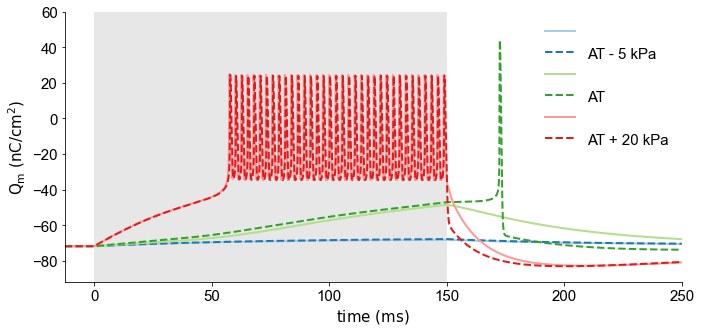

In [7]:
# Amplitudes
Athr = nbls.titrate(AcousticDrive(Fdrive), CW_pp)
regime_amps = {
    'AT - 5 kPa': subthr(Athr),
    'AT': Athr,
    'AT + 20 kPa': suprathr(Athr)
}

# Get outputs (using a generator expression to avoid overloading the memory)
outputs = (
    nbls.getOutput(AcousticDrive(Fdrive, x), CW_pp, cov, method, None, outputdir=subdir)
    for x in regime_amps.values() for method in methods
)

# Plot
figs['a_Qtraces'] = CompTimeSeries(outputs, 'Qm').render(
    labels=altLabels(regime_amps.keys()),
    lines=['-', '--'] * len(regime_amps),
    colors=plt.get_cmap('Paired').colors[:2 * len(regime_amps)],
    fs=fs, patches='one', figsize=Qtrace_figsize)

Comparison of spiking metrics for CW stimuli at various supra-threshold amplitudes. **The rendering may take a few seconds...**

In [ ]:
# Amplitudes
suprathr_amps = np.array([50, 100, 300, 600]) * 1e3  # Pa

# Get outputs (using a generator expression to avoid overloading the memory)
def gen(method):
    return (nbls.getOutput(AcousticDrive(Fdrive, x), CW_pp, cov, method, None, outputdir=subdir)
            for x in suprathr_amps)
outputs = {method: gen(method) for method in methods}

# Compute spiking metrics on them
metrics = {pneuron.name: {k: computeSpikingMetrics(v) for k, v in outputs.items()}}

# Plot
figs['a_spikemetrics'] = plotSpikingMetrics(
    suprathr_amps * 1e-3, 'Amplitude (kPa)', metrics,
    logscale=True, fs=fs, ps=ps, figsize=metrics_figsize)

## Panel B: comparison across US frequencies

In [ ]:
pneuron = getPointNeuron('RS')
nbls = NeuronalBilayerSonophore(a, pneuron)
freqs = np.array([20e3, 100e3, 500e3, 1e6, 2e6, 3e6, 4e6])  # Hz

Comparison of $Q_m$ traces for supra-threshold CW stimuli at low and high US frequencies. **The rendering may take a few seconds...**

In [ ]:
# Frequencies and corresponding supra-threshold amplitudes
freqs_traces = [freqs.min(), freqs.max()]
amps_traces = [suprathr(nbls.titrate(AcousticDrive(x), CW_pp)) for x in freqs_traces]  # Pa

# Get outputs (using a generator expression to avoid overloading the memory)
outputs = (
    nbls.getOutput(AcousticDrive(x, y), CW_pp, cov, method, None, outputdir=subdir)
    for x, y in zip(freqs_traces, amps_traces) for method in methods
)

# Plot
figs['b_Qtraces'] = CompTimeSeries(outputs, 'Qm').render(
    labels=altLabels([f'{si_format(f)}Hz' for f in freqs_traces]),
    lines=['-', '--'] * len(freqs_traces),
    colors=plt.get_cmap('Paired').colors[6:10],
    fs=fs, patches='one', figsize=Qtrace_figsize,
    inset={'xcoords': [5, 40], 'ycoords': [-35, 45], 'xlims': [57.5, 58.5], 'ylims': [10, 35]})

Comparison of spiking metrics for CW stimuli for supra-threshold amplitudes at various frequencies. **The rendering may take a few seconds...**

In [ ]:
# Frequencies and corresponding supra-threshold amplitudes
suprathr_amps = [suprathr(nbls.titrate(AcousticDrive(x), CW_pp)) for x in freqs]  # Pa

# Get outputs (using a generator expression to avoid overloading the memory)
def gen(method):
    return (nbls.getOutput(AcousticDrive(x, y), CW_pp, cov, method, None, outputdir=subdir)
            for x, y in zip(freqs, suprathr_amps))
outputs = {method: gen(method) for method in methods}

# Compute spiking metrics on them
metrics = {pneuron.name: {k: computeSpikingMetrics(v) for k, v in outputs.items()}}

# Plot
figs['b_spikemetrics'] = plotSpikingMetrics(
    freqs * 1e-3, 'Frequency (kHz)', metrics,
    logscale=True, fs=fs, ps=ps, figsize=metrics_figsize)

## Panel C: comparison across sonophore radii

In [ ]:
pneuron = getPointNeuron('RS')
nbls = NeuronalBilayerSonophore(a, pneuron)
radii = np.array([16, 22.6, 32, 45.3, 64]) * 1e-9  # m

Comparison of $Q_m$ traces for supra-threshold CW stimuli with small and large sonophore radii. **The rendering may take a few seconds...**

In [ ]:
# Radii and corresponding supra-threshold amplitudes
radii_traces = [radii.min(), radii.max()]
amps_traces = [suprathr(NeuronalBilayerSonophore(x, pneuron).titrate(AcousticDrive(Fdrive), CW_pp))
               for x in radii_traces]  # Pa

# Get outputs (using a generator expression to avoid overloading the memory)
outputs = (
    NeuronalBilayerSonophore(x, pneuron).getOutput(AcousticDrive(Fdrive, y), CW_pp, cov, method, None, outputdir=subdir)
    for x, y in zip(radii_traces, amps_traces) for method in methods
)

# Plot
colors = plt.get_cmap('Paired').colors
colors = colors[2:4] + colors[10:12]
figs['c_Qtraces'] = CompTimeSeries(outputs, 'Qm').render(
    labels=altLabels([f'{x * 1e9:.0f} nm' for x in radii_traces]),
    lines=['-', '--'] * len(radii_traces), colors=colors,
    fs=fs, patches='one', figsize=Qtrace_figsize)

Comparison of spiking metrics for CW stimuli for supra-threshold amplitudes for various sonophore radii. **The rendering may take a few seconds...**

In [ ]:
# Radii and corresponding supra-threshold amplitudes
suprathr_amps = [suprathr(NeuronalBilayerSonophore(x, pneuron).titrate(AcousticDrive(Fdrive), CW_pp))
                 for x in radii]  # Pa

# Get outputs (using a generator expression to avoid overloading the memory)
def gen(method):
    return (NeuronalBilayerSonophore(x, pneuron).getOutput(AcousticDrive(Fdrive, y), CW_pp, cov, method, None, outputdir=subdir)
            for x, y in zip(radii, suprathr_amps))
outputs = {method: gen(method) for method in methods}

# Compute spiking metrics on them
metrics = {pneuron.name: {k: computeSpikingMetrics(v) for k, v in outputs.items()}}

# Plot
figs['c_spikemetrics'] = plotSpikingMetrics(
    radii * 1e9, 'Sonophore radius (nm)', metrics,
    logscale=True, fs=fs, ps=ps, figsize=metrics_figsize)

## Panel D: comparison across duty cycles

In [ ]:
neurons = ['RS', 'LTS']
pneurons = [getPointNeuron(x) for x in neurons]
colors = list(plt.get_cmap('Paired').colors[:6])
del colors[2:4]
DCs = np.array([5, 10, 25, 50, 75, 100]) * 1e-2
DC_short = DCs.min()

Comparison of $Q_m$ traces at for RS and LTS neurons at 100 kPa, 5% duty cycle. **The rendering may take a few seconds...**

In [ ]:
# Short duty-cycle protocol
short_pp = PulsedProtocol(tstim, toffset, PRF, DC_short)

# Get outputs (using a generator expression to avoid overloading the memory)
outputs = (
    NeuronalBilayerSonophore(a, x).getOutput(AcousticDrive(Fdrive, Adrive), short_pp, cov, method, None, outputdir=subdir)
    for x in pneurons for method in methods
)

# Plot
figs['d_Qtraces'] = CompTimeSeries(outputs, 'Qm').render(
    labels=altLabels([f'{x.name}, {short_pp.DC * 1e2:.0f}% DC' for x in pneurons]),
    lines=['-', '--'] * len(pneurons), colors=colors,
    fs=fs, patches='one', figsize=Qtrace_figsize)

Comparison of spiking metrics for PW stimuli at various duty cycles for RS and LTS neurons. **The rendering may take a few seconds...**

In [ ]:
# Get outputs (using a generator expression to avoid overloading the memory)
def gen(pneuron, method):
    return (
        NeuronalBilayerSonophore(a, pneuron).getOutput(
            AcousticDrive(Fdrive, Adrive), PulsedProtocol(tstim, toffset, PRF, x), cov, method, None, outputdir=subdir)
        for x in DCs)
outputs = {
    pneuron.name: {method: gen(pneuron, method) for method in methods}
    for pneuron in pneurons
}

# Compute spiking metrics on them
metrics = {
    key: {k: computeSpikingMetrics(v) for k, v in value.items()}
    for key, value in outputs.items()
}

# Plot
colors_dict = {pneuron.name: {method: colors[2 * i + j] for j, method in enumerate(methods)}
               for i, pneuron in enumerate(pneurons)}
figs['d_spikemetrics'] = plotSpikingMetrics(
    DCs * 1e2, 'Duty cycle (%)', metrics,
    spikeamp=False, colors=colors_dict,
    fs=fs, ps=ps, figsize=metrics_figsize)

## Panel E: comparison across pulse repetition frequencies

In [ ]:
pneuron = getPointNeuron('LTS')
nbls = NeuronalBilayerSonophore(a, pneuron)

Comparison of $Q_m$ traces for PW stimuli at 5% duty cycle with different pulse repetition frequencies. **The rendering may take a few seconds...**

In [ ]:
# Pulse-repetition frequencies
PRFs_traces = np.array([1e1, 1e2, 1e3, 1e4])  # Hz

# Get outputs (using a generator expression to avoid overloading the memory)
outputs = (
    nbls.getOutput(AcousticDrive(Fdrive, Adrive), PulsedProtocol(tstim, toffset, x, DC_short), cov, method, None, outputdir=subdir)
    for x in PRFs_traces for method in methods)

# Plot
patches = [False, True] * len(PRFs_traces)
patches[-1] = False
figs['e_Qtraces'] = CompTimeSeries(outputs, 'Qm').render(
    labels=altLabels([f'{si_format(x)}Hz PRF' for x in PRFs_traces]),
    lines=['-', '--'] * len(PRFs_traces),
    colors=plt.get_cmap('Paired').colors[4:12],
    fs=fs, patches=patches, figsize=Qtrace_figsize)

Comparison of spiking metrics for PW stimuli at 5% duty cycle with different pulse repetition frequencies. **The rendering may take a few seconds...**

In [ ]:
# Pulse-repetition frequencies
PRFs_dense = sum([[x, 2 * x, 5 * x] for x in PRFs_traces[:-1]], []) + [PRFs_traces[-1]]  # Hz

# Get outputs (using a generator expression to avoid overloading the memory)
def gen(method):
    return (nbls.getOutput(
        AcousticDrive(Fdrive, Adrive), PulsedProtocol(tstim, toffset, x, DC_short), cov, method, None, outputdir=subdir)
        for x in PRFs_dense)
outputs = {method: gen(method) for method in methods}

# Compute spiking metrics on them
metrics = {pneuron.name: {k: computeSpikingMetrics(v) for k, v in outputs.items()}}

# Plot
figs['e_spikemetrics'] = plotSpikingMetrics(
    PRFs_dense, 'PRF (Hz)', metrics,
    spikeamp=False, logscale=True,
    fs=fs, ps=ps, figsize=metrics_figsize)

### Save figure panels

Save figure panels as **pdf** in the *figs* sub-folder:

In [ ]:
saveFigsAsPDF(figs, figindex)